### 教程链接如下：https://ai.plainenglish.io/building-and-training-a-transformer-from-scratch-fdbf3db00df4

#### 中英文翻译数据集：https://zhuanlan.zhihu.com/p/651736596
#### 动态演示：https://jalammar.github.io/illustrated-transformer/

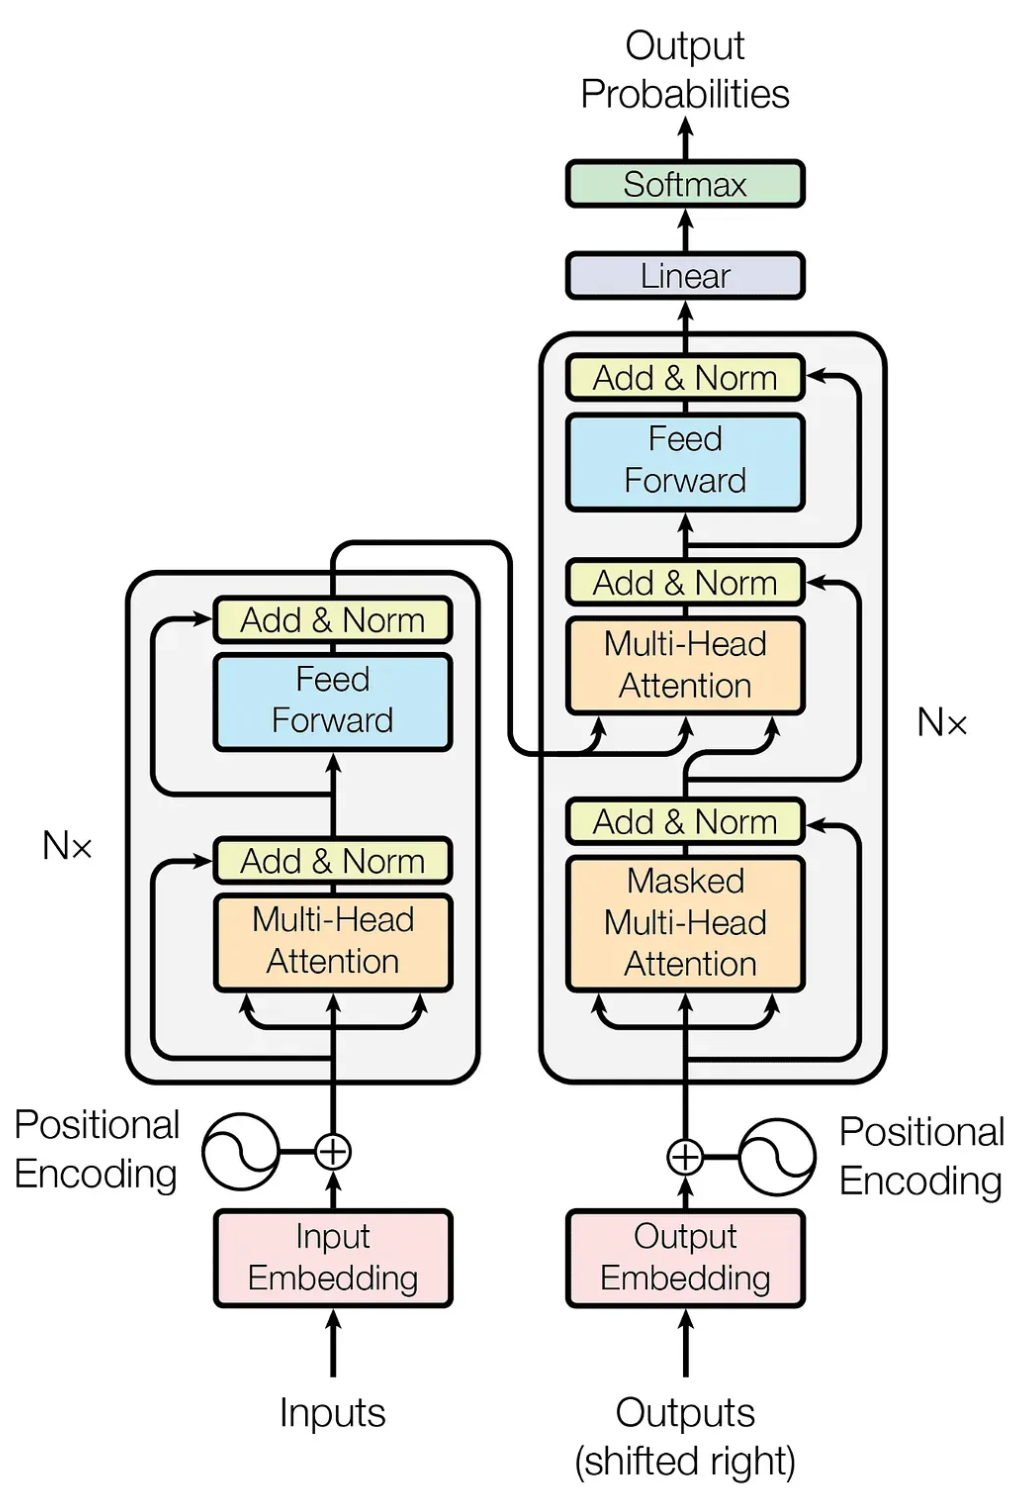
# 本教程将复现transformer的各个组件，从零构建一个transformer模型

In [2]:
# Importing libraries

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

# Math
import math

# HuggingFace libraries 
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

# Pathlib 
from pathlib import Path

# typing
from typing import Any

# Library for progress bars in loops
from tqdm import tqdm

# Importing library of warnings
import warnings

### 观察transformer框架图，我们可以发现，encoder和decoder的第一层是一个embedding网络，该层将输入序列的每一个词，转换成一个高维向量表示
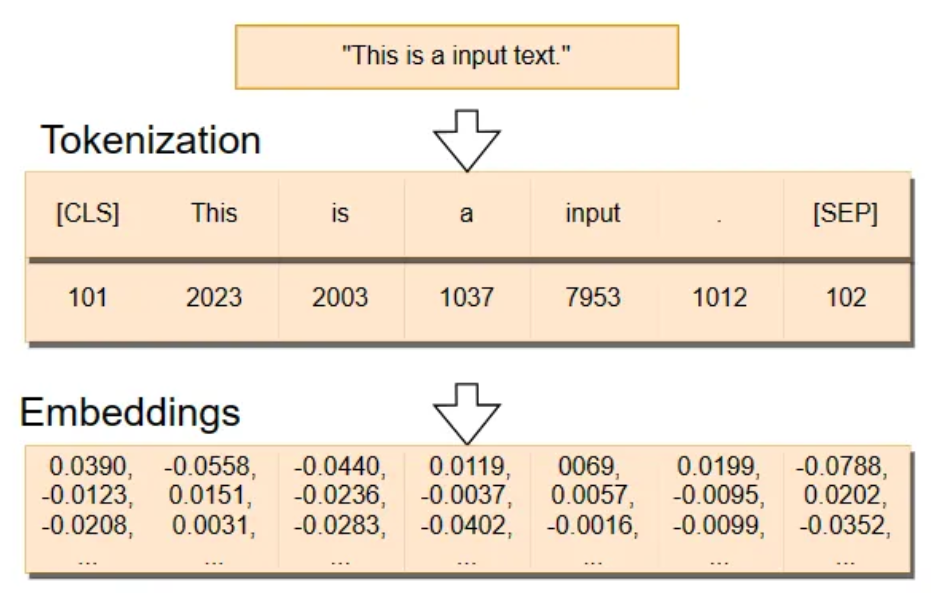

In [3]:
# Creating Input Embeddings
class InputEmbeddings(nn.Module):
    
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model # Dimension of vectors (512)
        self.vocab_size = vocab_size # Size of the vocabulary
        self.embedding = nn.Embedding(vocab_size, d_model) # PyTorch layer that converts integer indices to dense embeddings
        
    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model) # Normalizing the variance of the embeddings

# 此例子将每个单词转换成20维的向量
inputEmbedding = InputEmbeddings(20, 20000)
wordEmbedding = inputEmbedding(torch.tensor(1))
print(wordEmbedding)

tensor([-0.1083, -0.4157,  5.5786,  0.2293,  1.9126,  7.1288, -1.7831, -1.6798,
        -1.7647, -1.8995,  2.3916, -0.0582,  2.0158,  1.0144,  2.0383, -2.9424,
        -0.7437, -1.8367, -1.5002, -4.7382], grad_fn=<MulBackward0>)


### 在embedding之后，模型将每个单词加上了一个与embedding相同维度的位置向量。
#### 为什么需要位置向量呢？举个例子：“杭州是一个比苏州更漂亮的城市”，这个句子中有两个“州”字，那么embedding得到的词向量是一样的，表达的是相同的意思。很显然，这两个州字有不一样的含义。于是，就有了位置向量。位置向量主要起到以下作用：1，每个单词的Token都能包含它的位置信息；2，模型可以看到文字之间的距离；3，模型可以看懂并学习到位置编码的规则。

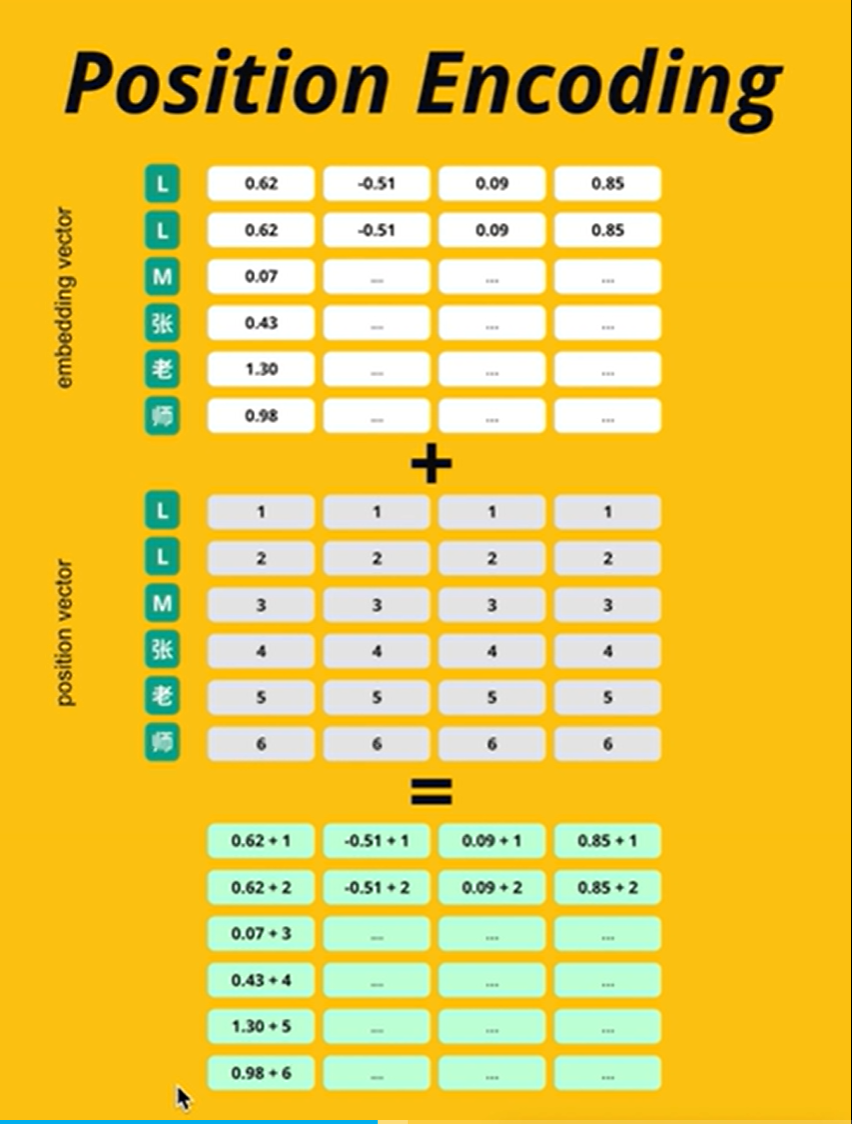
#### 假设用上图所示的位置矩阵来表示位置信息，在数值上是可以表达每个单词的不同位置的，但是存在两个问题。
##### 1，当句子很长的时候，后面的位置数字越来越大，导致向量中的值的差异很大，数值大的相乘就会变得更大，从而使得信息表示不准确。（需要将位置数值约束在一定大小内）
##### 2，对于相同的单词，它在不同位置的时候，语义会有变化，也就是说希望模型能够关注到该词的特定维度上的数值，而不是所有维度的值都受到相同程度的关注。（对同一个单词不同维度的数值应该添加不一样的位置标记）
#### 因此，使用正余弦函数计算词向量的位置向量

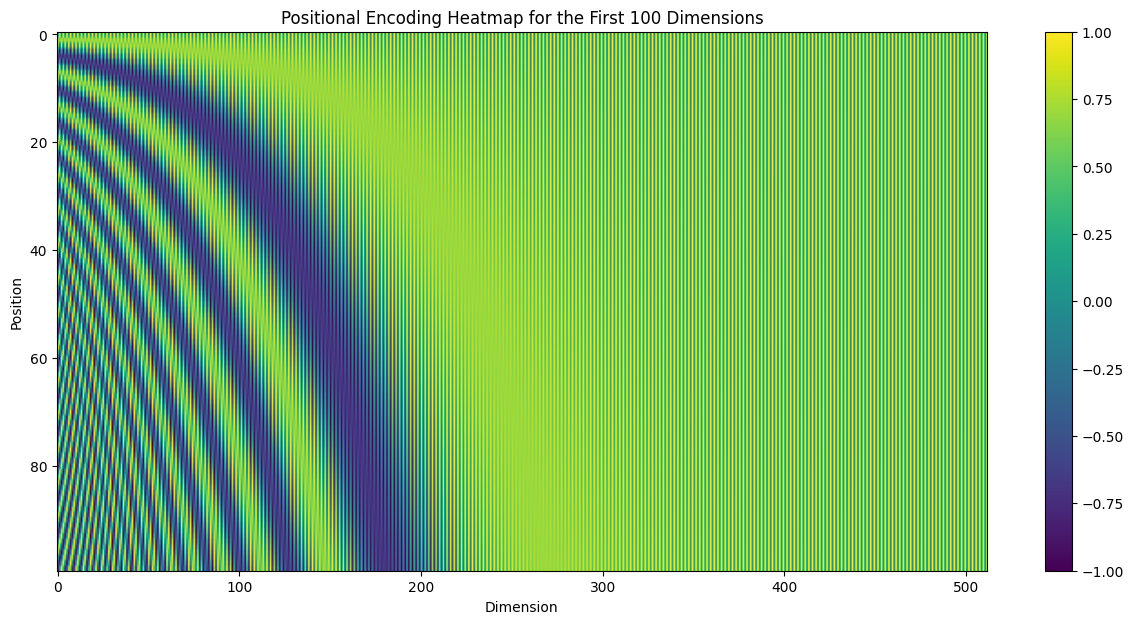

In [4]:
import torch
import math
import matplotlib.pyplot as plt

class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model  # 模型的维度
        self.seq_len = seq_len  # 最大序列长度
        self.dropout = nn.Dropout(dropout)  # 防止过拟合的 dropout 层
        
        # 创建一个形状为 (seq_len, d_model) 的位置编码矩阵，并用零填充
        pe = torch.zeros(seq_len, d_model)
        
        # 创建一个表示位置的张量 (0 到 seq_len - 1)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)  # 将 position 转换为 2D 张量 ['seq_len, 1']
        
        # 创建位置编码公式中的除法项
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # 对 pe 的偶数索引应用 sine
        pe[:, 0::2] = torch.sin(position * div_term)
        # 对 pe 的奇数索引应用 cosine
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # 在 pe 矩阵的开头添加一个额外的维度以处理批量
        pe = pe.unsqueeze(0)
        
        # 将 'pe' 注册为缓冲区。缓冲区是一个不被认为是模型参数的张量
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # 将位置编码添加到输入张量 x 上
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)  # 用于正则化的 dropout

# 参数
d_model = 512
seq_len = 100
dropout = 0.1

# 创建一个 PositionalEncoding 实例
pos_enc = PositionalEncoding(d_model, seq_len, dropout)

# 获取位置编码矩阵
pos_encoding = pos_enc.pe[0].detach().numpy()  # 形状: (seq_len, d_model)

# 可视化位置编码的热力图
plt.figure(figsize=(15, 7))
plt.imshow(pos_encoding, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel('Dimension')
plt.ylabel('Position')
plt.title('Positional Encoding Heatmap for the First 100 Dimensions')
plt.show()

#### 以下的LayerNormalization类对输入数据执行层归一化。在前向传播过程中，我们计算输入数据的均值和标准差。然后通过减去均值并除以标准差加上一个小数（称为epsilon）来避免除以零，从而对输入数据进行归一化。这个过程产生的归一化输出具有均值为0和标准差为1。

#### 接下来，我们通过一个可学习参数alpha对归一化输出进行缩放，并添加一个称为bias的可学习参数。训练过程负责调整这些参数。最终结果是一个经过层归一化的张量，确保网络中各层输入的尺度是一致的。

In [5]:
# Creating Layer Normalization
class LayerNormalization(nn.Module):
    
    def __init__(self, eps: float = 10**-6) -> None: # We define epsilon as 0.000001 to avoid division by zero
        super().__init__()
        self.eps = eps
        
        # We define alpha as a trainable parameter and initialize it with ones
        self.alpha = nn.Parameter(torch.ones(1)) # One-dimensional tensor that will be used to scale the input data
        
        # We define bias as a trainable parameter and initialize it with zeros
        self.bias = nn.Parameter(torch.zeros(1)) # One-dimensional tenso that will be added to the input data
        
    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True) # Computing the mean of the input data. Keeping the number of dimensions unchanged
        std = x.std(dim = -1, keepdim = True) # Computing the standard deviation of the input data. Keeping the number of dimensions unchanged
        
        # Returning the normalized input
        return self.alpha * (x-mean) / (std + self.eps) + self.bias

# Creating Feed Forward Layers
class FeedForwardBlock(nn.Module):
    
    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        # First linear transformation
        self.linear_1 = nn.Linear(d_model, d_ff) # W1 & b1
        self.dropout = nn.Dropout(dropout) # Dropout to prevent overfitting
        # Second linear transformation
        self.linear_2 = nn.Linear(d_ff, d_model) # W2 & b2
        
    def forward(self, x):
        # (Batch, seq_len, d_model) --> (batch, seq_len, d_ff) -->(batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

layerNorm = LayerNormalization()
normedVector = layerNorm(wordEmbedding)
print(wordEmbedding)
print(normedVector)

tensor([-0.1083, -0.4157,  5.5786,  0.2293,  1.9126,  7.1288, -1.7831, -1.6798,
        -1.7647, -1.8995,  2.3916, -0.0582,  2.0158,  1.0144,  2.0383, -2.9424,
        -0.7437, -1.8367, -1.5002, -4.7382], grad_fn=<MulBackward0>)
tensor([-0.0889, -0.1982,  1.9323,  0.0311,  0.6293,  2.4832, -0.6842, -0.6475,
        -0.6777, -0.7256,  0.7996, -0.0711,  0.6660,  0.3101,  0.6740, -1.0962,
        -0.3148, -0.7032, -0.5837, -1.7345], grad_fn=<AddBackward0>)


#### 多头注意力模块，这个模块的公式很好理解，就是query与key计算相关性，然后使用计算得到的相关性数值作为系数，对value进行加权求和

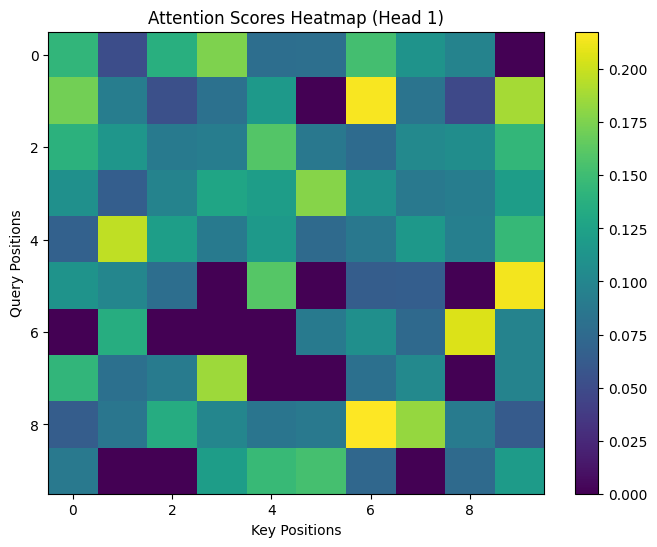

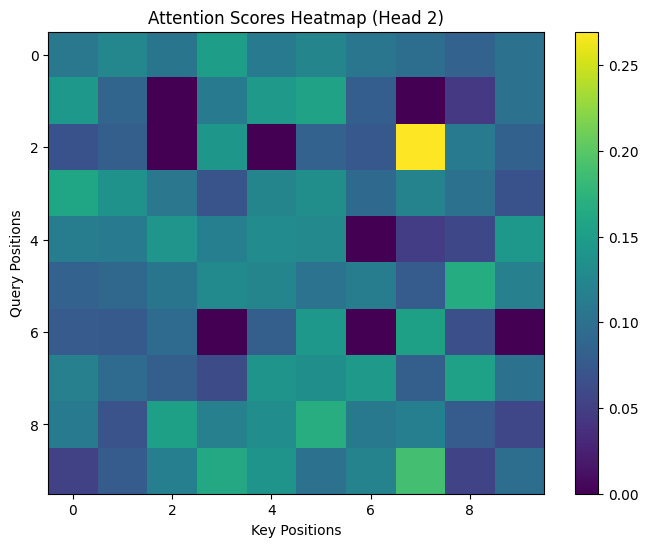

In [6]:
import math
import matplotlib.pyplot as plt

class MultiHeadAttentionBlock(nn.Module):
    
    def __init__(self, d_model: int, h: int, dropout: float) -> None: # h = number of heads
        super().__init__()
        self.d_model = d_model
        self.h = h
        
        # We ensure that the dimensions of the model is divisible by the number of heads
        assert d_model % h == 0, 'd_model is not divisible by h'
        
        # d_k is the dimension of each attention head's key, query, and value vectors
        self.d_k = d_model // h # d_k formula, like in the original "Attention Is All You Need" paper
        
        # Defining the weight matrices
        self.w_q = nn.Linear(d_model, d_model) # W_q
        self.w_k = nn.Linear(d_model, d_model) # W_k
        self.w_v = nn.Linear(d_model, d_model) # W_v
        self.w_o = nn.Linear(d_model, d_model) # W_o
        
        self.dropout = nn.Dropout(dropout) # Dropout layer to avoid overfitting
        
    
    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):# mask => When we want certain words to NOT interact with others, we "hide" them
        
        d_k = query.shape[-1] # The last dimension of query, key, and value
        
        # We calculate the Attention(Q,K,V) as in the formula in the image above 
        attention_scores = (query @ key.transpose(-2,-1)) / math.sqrt(d_k) # @ = Matrix multiplication sign in PyTorch
        
        # Before applying the softmax, we apply the mask to hide some interactions between words
        if mask is not None: # If a mask IS defined...
            attention_scores.masked_fill_(mask == 0, -1e9) # Replace each value where mask is equal to 0 by -1e9
        attention_scores = attention_scores.softmax(dim = -1) # Applying softmax
        if dropout is not None: # If a dropout IS defined...
            attention_scores = dropout(attention_scores) # We apply dropout to prevent overfitting
            
        return (attention_scores @ value), attention_scores # Multiply the output matrix by the V matrix, as in the formula
        
    def forward(self, q, k, v, mask): 
        
        query = self.w_q(q) # Q' matrix
        key = self.w_k(k) # K' matrix
        value = self.w_v(v) # V' matrix
        
        
        # Splitting results into smaller matrices for the different heads
        # Splitting embeddings (third dimension) into h parts
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension
        
        # Obtaining the output and the attention scores
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        
        # Obtaining the H matrix
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)
        
        return self.w_o(x) # Multiply the H matrix by the weight matrix W_o, resulting in the MH-A matrix

# Parameters
d_model = 512
h = 2
dropout = 0.1

# Create a MultiHeadAttentionBlock instance
multihead_attn_block = MultiHeadAttentionBlock(d_model, h, dropout)

# Example input tensors
q = torch.randn(1, 10, d_model)  # Query tensor
k = torch.randn(1, 10, d_model)  # Key tensor
v = torch.randn(1, 10, d_model)  # Value tensor
mask = None  # Example mask tensor

# Forward pass to get attention scores
_ = multihead_attn_block(q, k, v, mask)

# Visualize attention scores as heatmap for each head
for i in range(h):
    attention_scores = multihead_attn_block.attention_scores.squeeze()[i].detach().numpy()
    plt.figure(figsize=(8, 6))
    plt.imshow(attention_scores, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.xlabel('Key Positions')
    plt.ylabel('Query Positions')
    plt.title(f'Attention Scores Heatmap (Head {i+1})')
    plt.show()

#### 残差层，防止过拟合

In [7]:
# Building Residual Connection
class ResidualConnection(nn.Module):
    def __init__(self, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout) # We use a dropout layer to prevent overfitting
        self.norm = LayerNormalization() # We use a normalization layer 
    
    def forward(self, x, sublayer):
        # We normalize the input and add it to the original input 'x'. This creates the residual connection process.
        return x + self.dropout(sublayer(self.norm(x))) 

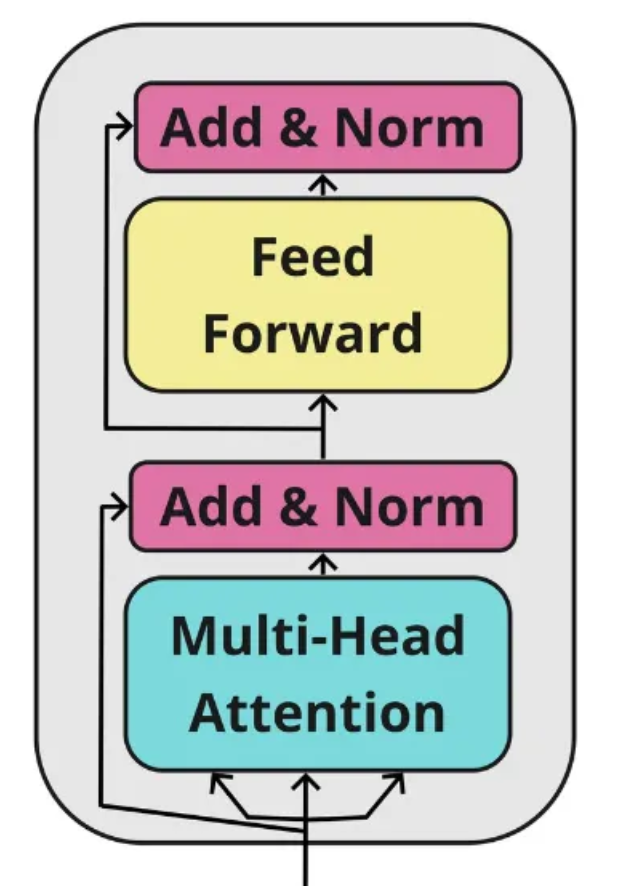
# =================================================================
# 综合以上模块，得到encoder类的代码如下：
# ==================================================================

In [8]:
# Building Encoder Block
class EncoderBlock(nn.Module):
    
    # This block takes in the MultiHeadAttentionBlock and FeedForwardBlock, as well as the dropout rate for the residual connections
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        # Storing the self-attention block and feed-forward block
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)]) # 2 Residual Connections with dropout
        
    def forward(self, x, src_mask):
        # Applying the first residual connection with the self-attention block
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask)) # Three 'x's corresponding to query, key, and value inputs plus source mask
        
        # Applying the second residual connection with the feed-forward block 
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x # Output tensor after applying self-attention and feed-forward layers with residual connections.

# Building Encoder 
# An Encoder can have several Encoder Blocks
class Encoder(nn.Module):
    
    # The Encoder takes in instances of 'EncoderBlock'
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers # Storing the EncoderBlocks
        self.norm = LayerNormalization() # Layer for the normalization of the output of the encoder layers
        
    def forward(self, x, mask):
        # Iterating over each EncoderBlock stored in self.layers
        for layer in self.layers:
            x = layer(x, mask) # Applying each EncoderBlock to the input tensor 'x'
        return self.norm(x) # Normalizing output

###############################
# 单个encoderBlock模块的数值模拟
##############################
# Define dimensions
# 此处 d_model 和 h 要是倍数关系，如果不是，会导致MultiHeadAttentionBlock报错，这个为什么要倍数关系？？？
d_model = 20    
h = 4
d_ff = 80
dropout = 0.1

# Create instances of blocks
self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
encoder_block = EncoderBlock(self_attention_block, feed_forward_block, dropout)

# Create sample input data (batch_size, seq_len, d_model)
x = torch.randn(1, 3, d_model)
src_mask = None  # Assuming no mask for this example

# Forward pass through encoder block
output = encoder_block(x, src_mask)

# Print input and output shapes and values
print("EncoderBlock Input:", x)
print("EncoderBlock Input shape:", x.shape)
print("EncoderBlock Output:", output)
print("EncoderBlock Output shape:", output.shape)


###############################
# 6个encoderBlock组成的encoder模块的数值模拟
##############################
# Create a list of encoder blocks
num_layers = 6
encoder_blocks = nn.ModuleList([EncoderBlock(self_attention_block, feed_forward_block, dropout) for _ in range(num_layers)])

# Create Encoder instance
encoder = Encoder(encoder_blocks)

# Forward pass through encoder
output = encoder(x, src_mask)

# Print input and output shapes and values
print("Encoder Input:", x)
print("Encoder Input shape:", x.shape)
print("Encoder Output:", output)
print("Encoder Output shape:", output.shape)

EncoderBlock Input: tensor([[[-0.9234,  0.6425, -0.5794, -1.1872, -1.6242,  0.5282, -0.9149,
           1.5161,  0.8237, -0.5029,  1.7127,  0.2799,  0.3583, -0.3342,
           0.8124,  0.5234, -2.6015, -0.4853, -0.8977, -1.4469],
         [-0.5714, -0.1192,  0.8519, -1.0009, -0.1887, -1.2525, -1.5665,
           1.3082, -1.5511, -1.3115,  0.1764, -0.9375,  2.4523, -0.3249,
           0.2368, -1.2484,  0.9558,  0.6947, -0.3500,  1.7921],
         [-0.1057,  1.2843,  0.1056,  0.8536, -2.2523, -2.2965, -0.1806,
           1.4785,  0.3059,  0.8212,  0.3663, -1.6330,  0.4858,  0.7946,
           0.1384,  0.2223, -1.3000, -0.1878, -1.0465,  0.3963]]])
EncoderBlock Input shape: torch.Size([1, 3, 20])
EncoderBlock Output: tensor([[[-1.1910,  1.1439, -0.5540, -1.0208, -1.7184,  1.0305, -1.0929,
           0.7881,  0.8118, -0.6634,  1.7754,  0.7622,  0.3560, -0.4484,
           1.4061,  0.6970, -2.6155, -0.3771, -0.7929, -1.5734],
         [-0.4186,  0.5805,  0.6653, -1.5717, -0.5733, -0.3882, 

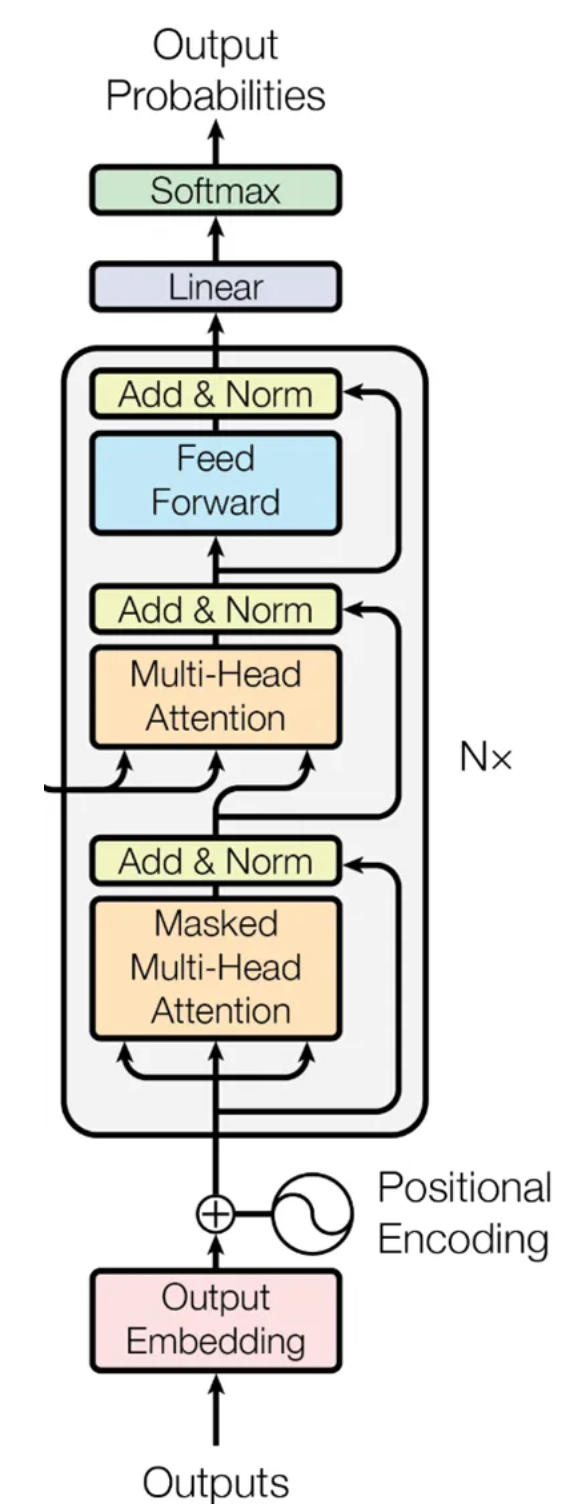
# =================================================================
# 根据上图结构，得到decoder类的代码如下：
# ==================================================================
解码器（Decoder）也由多个解码器块（DecoderBlock）组成，在原始论文中重复了六次。主要区别在于，它有一个额外的子层，该子层执行多头注意力机制，并具有交叉注意力组件，该组件使用编码器（Encoder）的输出作为键（keys）和值（values），同时使用解码器的输入作为查询（queries）。

自注意力子层（self-attention sub-layer）是带有掩码的，这限制了模型看到序列中的当前字符后面的内容。

decoder的最后串接了一个ProjectionLayer层，负责将模型的输出转换为词汇表上的概率分布，从中我们可以从可能的词汇表中选择每个输出对应的单词。

In [20]:
# Building Decoder Block
class DecoderBlock(nn.Module):
    
    # The DecoderBlock takes in two MultiHeadAttentionBlock. One is self-attention, while the other is cross-attention.
    # It also takes in the feed-forward block and the dropout rate
    def __init__(self,  self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)]) # List of three Residual Connections with dropout rate
        
    def forward(self, x, encoder_output, src_mask, tgt_mask):        
        # Self-Attention block with query, key, and value plus the target language mask
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        
        # The Cross-Attention block using two 'encoder_ouput's for key and value plus the source language mask. It also takes in 'x' for Decoder queries
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        
        # Feed-forward block with residual connections
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

# Building Decoder
# A Decoder can have several Decoder Blocks
class Decoder(nn.Module):
    
    # The Decoder takes in instances of 'DecoderBlock'
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        
        # Storing the 'DecoderBlock's
        self.layers = layers
        self.norm = LayerNormalization() # Layer to normalize the output
        
    def forward(self, x, encoder_output, src_mask, tgt_mask):
        
        # Iterating over each DecoderBlock stored in self.layers
        for layer in self.layers:
            # Applies each DecoderBlock to the input 'x' plus the encoder output and source and target masks
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x) # Returns normalized output

# Buiding Linear Layer
class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int) -> None: # Model dimension and the size of the output vocabulary
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size) # Linear layer for projecting the feature space of 'd_model' to the output space of 'vocab_size'
    def forward(self, x):
        return torch.log_softmax(self.proj(x), dim = -1) # Applying the log Softmax function to the output


# 数值模拟实验
# 假设我们有以下配置和输入
d_model = 20
h = 4
dropout = 0.1
seq_len = 3
batch_size = 1
d_ff = 80
num_layers = 6
vocab_size = 10000

# 随机初始化输入数据和掩码
encoder_output = torch.rand(batch_size, seq_len, d_model)
x = torch.rand(batch_size, seq_len, d_model)
src_mask = None   # mask的维度应该是什么样子的？？？ 具体见数据集模块的示例
tgt_mask = None

# 实例化模块
self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout=dropout)
decoder_block = DecoderBlock(self_attention_block, cross_attention_block, feed_forward_block, dropout)

decoder_blocks = nn.ModuleList([DecoderBlock(self_attention_block, cross_attention_block, feed_forward_block, dropout) for _ in range(num_layers)])
decoder = Decoder(decoder_blocks)

# 模拟前向传递
decoderblockoutput = decoder_block(x, encoder_output, src_mask, tgt_mask)
print(decoderblockoutput)
print("Decoder Block Output Shape:", decoderblockoutput.shape)

output = decoder(x, encoder_output, src_mask, tgt_mask)
print(output)
print("Decoder Output Shape:", output.shape)

decoder输入： tensor([[[0.1931, 0.6281, 0.9491, 0.1498, 0.7520, 0.6458, 0.1290, 0.0135,
          0.9193, 0.0946, 0.2692, 0.3787, 0.4485, 0.1394, 0.9250, 0.0393,
          0.4988, 0.3837, 0.1116, 0.2307],
         [0.4881, 0.5252, 0.0824, 0.9419, 0.6860, 0.5693, 0.8139, 0.5485,
          0.9986, 0.0050, 0.4807, 0.0506, 0.8935, 0.4648, 0.5420, 0.9282,
          0.5575, 0.3371, 0.5473, 0.7764],
         [0.5036, 0.1844, 0.8809, 0.7243, 0.0883, 0.8954, 0.8372, 0.6688,
          0.1945, 0.6147, 0.8306, 0.5190, 0.8591, 0.3059, 0.0800, 0.8066,
          0.1945, 0.3578, 0.5532, 0.2153]]])
encoder输出： tensor([[[0.8986, 0.4858, 0.9419, 0.1310, 0.6064, 0.2904, 0.7470, 0.3380,
          0.8756, 0.7954, 0.7936, 0.4368, 0.7026, 0.5158, 0.5942, 0.0417,
          0.7960, 0.3652, 0.7855, 0.0376],
         [0.6540, 0.7346, 0.7578, 0.3217, 0.9707, 0.4175, 0.1976, 0.6694,
          0.2514, 0.8238, 0.9769, 0.8340, 0.8914, 0.9250, 0.3968, 0.6194,
          0.4652, 0.7383, 0.4435, 0.2876],
         [0.3185, 0.9

# 构建Transformer类。将上面所有的组件集成到一起，就可以构建一个完整的transformer

In [28]:
# Creating the Transformer Architecture
class Transformer(nn.Module):
    
    # This takes in the encoder and decoder, as well the embeddings for the source and target language.
    # It also takes in the Positional Encoding for the source and target language, as well as the projection layer
    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer
        
    # Encoder     
    def encode(self, src, src_mask):
        src = self.src_embed(src) # Applying source embeddings to the input source language
        src = self.src_pos(src) # Applying source positional encoding to the source embeddings
        return self.encoder(src, src_mask) # Returning the source embeddings plus a source mask to prevent attention to certain elements
    
    # Decoder
    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embed(tgt) # Applying target embeddings to the input target language (tgt)
        tgt = self.tgt_pos(tgt) # Applying target positional encoding to the target embeddings
        
        # Returning the target embeddings, the output of the encoder, and both source and target masks
        # The target mask ensures that the model won't 'see' future elements of the sequence
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)
    
    # Applying Projection Layer with the Softmax function to the Decoder output
    def project(self, x):
        return self.projection_layer(x)

# Building & Initializing Transformer

# Definin function and its parameter, including model dimension, number of encoder and decoder stacks, heads, etc.
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff: int = 2048) -> Transformer:
    
    # Creating Embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size) # Source language (Source Vocabulary to 512-dimensional vectors)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size) # Target language (Target Vocabulary to 512-dimensional vectors)
    
    # Creating Positional Encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout) # Positional encoding for the source language embeddings
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout) # Positional encoding for the target language embeddings
    
    # Creating EncoderBlocks
    encoder_blocks = [] # Initial list of empty EncoderBlocks
    for _ in range(N): # Iterating 'N' times to create 'N' EncoderBlocks (N = 6)
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Self-Attention
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout) # FeedForward
        
        # Combine layers into an EncoderBlock
        encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block) # Appending EncoderBlock to the list of EncoderBlocks
        
    # Creating DecoderBlocks
    decoder_blocks = [] # Initial list of empty DecoderBlocks
    for _ in range(N): # Iterating 'N' times to create 'N' DecoderBlocks (N = 6)
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Self-Attention
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Cross-Attention
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout) # FeedForward
        
        # Combining layers into a DecoderBlock
        decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block) # Appending DecoderBlock to the list of DecoderBlocks
        
    # Creating the Encoder and Decoder by using the EncoderBlocks and DecoderBlocks lists
    encoder = Encoder(nn.ModuleList(encoder_blocks))
    decoder = Decoder(nn.ModuleList(decoder_blocks))
    
    # Creating projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size) # Map the output of Decoder to the Target Vocabulary Space
    
    # Creating the transformer by combining everything above
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)
    
    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
            
    return transformer # Assembled and initialized Transformer. Ready to be trained and validated!

### Transformer输入的文本需要首先经过数字化处理，将每个单词转换成一个唯一的数字标识，这个步骤由Tokenizer完成。除了语料中的token，训练时会添加如下特殊token。
[UNK]: This token is used to identify an unknown word in the sequence.

[PAD]: Padding token to ensure that all sequences in a batch have the same length, so we pad shorter sentences with this token. We use attention masks to “tell” the model to ignore the padded tokens during training since they don’t have any real meaning to the task.

[SOS]: This is a token used to signal the Start of Sentence.

[EOS]: This is a token used to signal the End of Sentence.
### 一下方法根据配置路径返回预训练好的tokenizer，若不存在预训练好的tokenizer，则根据给定的dataset重新训练一个tokenizer

In [22]:
# Defining Tokenizer
def build_tokenizer(config, ds, lang):
    
    # Crating a file path for the tokenizer 
    tokenizer_path = Path(config['tokenizer_file'].format(lang))
    
    # Checking if Tokenizer already exists
    if not Path.exists(tokenizer_path): 
        
        # If it doesn't exist, we create a new one
        tokenizer = Tokenizer(WordLevel(unk_token = '[UNK]')) # Initializing a new world-level tokenizer
        tokenizer.pre_tokenizer = Whitespace() # We will split the text into tokens based on whitespace
        
        # Creating a trainer for the new tokenizer
        trainer = WordLevelTrainer(special_tokens = ["[UNK]", "[PAD]", 
                                                     "[SOS]", "[EOS]"], min_frequency = 2) # Defining Word Level strategy and special tokens
        
        # Training new tokenizer on sentences from the dataset and language specified 
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer = trainer)
        tokenizer.save(str(tokenizer_path)) # Saving trained tokenizer to the file path specified at the beginning of the function
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path)) # If the tokenizer already exist, we load it
    return tokenizer # Returns the loaded tokenizer or the trained tokenizer

# 构建数据集，本教程预备做翻译任务
`get_ds` 函数被定义用于加载和准备训练和验证的数据集。在这个函数中，我们构建或加载分词器，拆分数据集，并创建数据加载器，这样模型就可以成功地以批处理方式迭代数据集。这些函数的结果是源语言和目标语言的分词器以及数据加载器对象。

In [23]:
# 数据集类，根据单词的数据集的索引id，返回对应语句的输入输出token串
class BilingualDataset(Dataset):
    
    # This takes in the dataset contaning sentence pairs, the tokenizers for target and source languages, and the strings of source and target languages
    # 'seq_len' defines the sequence length for both languages
    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len) -> None:
        super().__init__()
        
        self.seq_len = seq_len
        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        
        # Defining special tokens by using the target language tokenizer
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)

        
    # Total number of instances in the dataset (some pairs are larger than others)
    def __len__(self):
        return len(self.ds)
    
    # Using the index to retrive source and target texts
    def __getitem__(self, index: Any) -> Any:
        src_target_pair = self.ds[index]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]
        
        # Tokenizing source and target texts 
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids
        
        # Computing how many padding tokens need to be added to the tokenized texts 
        # Source tokens
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2 # Subtracting the two '[EOS]' and '[SOS]' special tokens
        # Target tokens
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1 # Subtracting the '[SOS]' special token
        
        # If the texts exceed the 'seq_len' allowed, it will raise an error. This means that one of the sentences in the pair is too long to be processed
        # given the current sequence length limit (this will be defined in the config dictionary below)
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError('Sentence is too long')
         
        # Building the encoder input tensor by combining several elements
        encoder_input = torch.cat(
            [
            self.sos_token, # inserting the '[SOS]' token
            torch.tensor(enc_input_tokens, dtype = torch.int64), # Inserting the tokenized source text
            self.eos_token, # Inserting the '[EOS]' token
            torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )
        
        # Building the decoder input tensor by combining several elements
        decoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token 
                torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        
        )
        
        # Creating a label tensor, the expected output for training the model
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                self.eos_token, # Inserting the '[EOS]' token 
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Adding padding tokens
                
            ]
        )
        
        # Ensuring that the length of each tensor above is equal to the defined 'seq_len'
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len
        
        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input, 
            'encoder_mask': (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(),
            'decoder_mask': (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() & casual_mask(decoder_input.size(0)), 
            'label': label,
            'src_text': src_text,
            'tgt_text': tgt_text
        }    

# Iterating through dataset to extract the original sentence and its translation 
def get_all_sentences(ds, lang):
    for pair in ds:
        yield pair['translation'][lang]

def get_ds(config):
    
    # Loading the train portion of the OpusBooks dataset.
    # The Language pairs will be defined in the 'config' dictionary we will build later
    # load_dataset 是 dataset中预定义的方法，会根据参数加载Hugging face数据集
    ds_raw = load_dataset('opus_books', f'{config["lang_src"]}-{config["lang_tgt"]}', split = 'train') 
    
    # Building or loading tokenizer for both the source and target languages 
    tokenizer_src = build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = build_tokenizer(config, ds_raw, config['lang_tgt'])
    
    # Splitting the dataset for training and validation 
    train_ds_size = int(0.9 * len(ds_raw)) # 90% for training
    val_ds_size = len(ds_raw) - train_ds_size # 10% for validation
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size]) # Randomly splitting the dataset
                                    
    # Processing data with the BilingualDataset class, which we will define below
    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
                                    
    # Iterating over the entire dataset and printing the maximum length found in the sentences of both the source and target languages
    max_len_src = 0
    max_len_tgt = 0
    for pair in ds_raw:
        src_ids = tokenizer_src.encode(pair['translation'][config['lang_src']]).ids
        tgt_ids = tokenizer_src.encode(pair['translation'][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))
        
    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')
    
    # Creating dataloaders for the training and validadion sets
    # Dataloaders are used to iterate over the dataset in batches during training and validation
    train_dataloader = DataLoader(train_ds, batch_size = config['batch_size'], shuffle = True) # Batch size will be defined in the config dictionary
    val_dataloader = DataLoader(val_ds, batch_size = 1, shuffle = True)
    
    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt # Returning the DataLoader objects and tokenizers

# Define settings for building and training the transformer model
def get_config():
    return{
        'batch_size': 1,
        'num_epochs': 20,
        'lr': 10**-4,
        'seq_len': 350,
        'd_model': 512, # Dimensions of the embeddings in the Transformer. 512 like in the "Attention Is All You Need" paper.
        'lang_src': 'en',
        'lang_tgt': 'it',
        'model_folder': 'weights',
        'model_basename': 'tmodel_',
        'preload': None,
        'tokenizer_file': 'tokenizer_{0}.json',
        'experiment_name': 'runs/tmodel'
    }

# Function to construct the path for saving and retrieving model weights
def get_weights_file_path(config, epoch: str):
    model_folder = config['model_folder'] # Extracting model folder from the config
    model_basename = config['model_basename'] # Extracting the base name for model files
    model_filename = f"{model_basename}{epoch}.pt" # Building filename
    return str(Path('.')/ model_folder/ model_filename) # Combining current directory, the model folder, and the model filename

config = get_config()
print(config)

{'batch_size': 1, 'num_epochs': 20, 'lr': 0.0001, 'seq_len': 350, 'd_model': 512, 'lang_src': 'en', 'lang_tgt': 'it', 'model_folder': 'weights', 'model_basename': 'tmodel_', 'preload': None, 'tokenizer_file': 'tokenizer_{0}.json', 'experiment_name': 'runs/tmodel'}


In [13]:
# 打印并检查数据集中的数据
# Retrieving dataloaders and tokenizers for source and target languages using the 'get_ds' function
train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)

Max length of source sentence: 309
Max length of target sentence: 274


In [24]:
# Fetching a single batch of data from the train_dataloader
for batch in train_dataloader:
    encoder_input = batch['encoder_input'] 
    decoder_input = batch['decoder_input']  
    encoder_mask = batch['encoder_mask']   
    decoder_mask = batch['decoder_mask']    
    label = batch['label']     
    src_text = batch['src_text']     
    print('encoder_input', encoder_input[0])
    print('decoder_input', decoder_input[0])
    print('encoder_mask', encoder_mask[0])
    print('decoder_mask', decoder_mask[0])
    print('label', label[0])
    print('src_text', src_text[0])
    break  # We break after the first batch to avoid printing the entire dataset

encoder_input tensor([   2,   62, 4328,   48,   21,  177, 3304,    4,   31,    5,  231,   48,
         443,   50,  121,   22,    0, 2661,   45,  101,   40,  236,   50,  662,
         102,   52,    5,    0,    7,    3,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1, 

##### 生成掩码矩阵。我们首先制作一个填充了1的方阵。我们用size参数来确定网格的大小。然后，我们将主对角线以上的所有数字变为0。主对角线一侧的每个数字变为0，而其余部分保持为1。

In [25]:
def casual_mask(size):
        # Creating a square matrix of dimensions 'size x size' filled with ones
        mask = torch.triu(torch.ones(1, size, size), diagonal = 1).type(torch.int)
        return mask == 0

print(casual_mask(10))

tensor([[[ True, False, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False, False],
         [ True,  True,  True,  True,  True, False, False, False, False, False],
         [ True,  True,  True,  True,  True,  True, False, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]])


# 模型训练，
### 包含 训练 以及 结果的验证
### 模型训练时，采用了teacher force策略，这个需要深入理解：https://www.zhihu.com/tardis/zm/art/644211164?source_id=1003   ；   https://zhuanlan.zhihu.com/p/93030328

In [29]:
# Define function to obtain the most probable next token
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    # Retrieving the indices from the start and end of sequences of the target tokens
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')
    
    # Computing the output of the encoder for the source sequence
    encoder_output = model.encode(source, source_mask)
    # Initializing the decoder input with the Start of Sentence token
    decoder_input = torch.empty(1,1).fill_(sos_idx).type_as(source).to(device)
    
    # Looping until the 'max_len', maximum length, is reached
    while True:
        if decoder_input.size(1) == max_len:
            break
            
        # Building a mask for the decoder input
        decoder_mask = casual_mask(decoder_input.size(1)).type_as(source_mask).to(device)
        
        # Calculating the output of the decoder
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)
        
        # Applying the projection layer to get the probabilities for the next token
        prob = model.project(out[:, -1])
        
        # Selecting token with the highest probability
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat([decoder_input, torch.empty(1,1). type_as(source).fill_(next_word.item()).to(device)], dim=1)
        
        # If the next token is an End of Sentence token, we finish the loop
        if next_word == eos_idx:
            break
            
    return decoder_input.squeeze(0) # Sequence of tokens generated by the decoder

# Defining function to evaluate the model on the validation dataset
# num_examples = 2, two examples per run
def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_state, writer, num_examples=2):
    model.eval() # Setting model to evaluation mode
    count = 0 # Initializing counter to keep track of how many examples have been processed
    
    console_width = 80 # Fixed witdh for printed messages
    
    # Creating evaluation loop
    with torch.no_grad(): # Ensuring that no gradients are computed during this process
        for batch in validation_ds:
            count += 1
            encoder_input = batch['encoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            
            # Ensuring that the batch_size of the validation set is 1
            assert encoder_input.size(0) ==  1, 'Batch size must be 1 for validation.'
            
            # Applying the 'greedy_decode' function to get the model's output for the source text of the input batch
            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)
            
            # Retrieving source and target texts from the batch
            source_text = batch['src_text'][0]
            target_text = batch['tgt_text'][0] # True translation 
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy()) # Decoded, human-readable model output
            
            # Printing results
            print_msg('-'*console_width)
            print_msg(f'SOURCE: {source_text}')
            print_msg(f'TARGET: {target_text}')
            print_msg(f'PREDICTED: {model_out_text}')
            
            # After two examples, we break the loop
            if count == num_examples:
                break

# We pass as parameters the config dictionary, the length of the vocabylary of the source language and the target language
def get_model(config, vocab_src_len, vocab_tgt_len):
    
    # Loading model using the 'build_transformer' function.
    # We will use the lengths of the source language and target language vocabularies, the 'seq_len', and the dimensionality of the embeddings
    model = build_transformer(vocab_src_len, vocab_tgt_len, config['seq_len'], config['seq_len'], config['d_model'])
    return model

def train_model(config):
    # Setting up device to run on GPU to train faster
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device {device}")
    
    # Creating model directory to store weights
    Path(config['model_folder']).mkdir(parents=True, exist_ok=True)
    
    # Retrieving dataloaders and tokenizers for source and target languages using the 'get_ds' function
    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
    
    # Initializing model on the GPU using the 'get_model' function
    model = get_model(config,tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)
    
    # Tensorboard
    writer = SummaryWriter(config['experiment_name'])
    
    # Setting up the Adam optimizer with the specified learning rate from the '
    # config' dictionary plus an epsilon value
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps = 1e-9)
    
    # Initializing epoch and global step variables
    initial_epoch = 0
    global_step = 0
    
    # Checking if there is a pre-trained model to load
    # If true, loads it
    if config['preload']:
        model_filename = get_weights_file_path(config, config['preload'])
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename) # Loading model
        
        # Sets epoch to the saved in the state plus one, to resume from where it stopped
        initial_epoch = state['epoch'] + 1
        # Loading the optimizer state from the saved model
        optimizer.load_state_dict(state['optimizer_state_dict'])
        # Loading the global step state from the saved model
        global_step = state['global_step']
        
    # Initializing CrossEntropyLoss function for training
    # We ignore padding tokens when computing loss, as they are not relevant for the learning process
    # We also apply label_smoothing to prevent overfitting
    loss_fn = nn.CrossEntropyLoss(ignore_index = tokenizer_src.token_to_id('[PAD]'), label_smoothing = 0.1).to(device)
    
    # Initializing training loop 
    
    # Iterating over each epoch from the 'initial_epoch' variable up to
    # the number of epochs informed in the config
    for epoch in range(initial_epoch, config['num_epochs']):
        
        # Initializing an iterator over the training dataloader
        # We also use tqdm to display a progress bar
        batch_iterator = tqdm(train_dataloader, desc = f'Processing epoch {epoch:02d}')
        
        # For each batch...
        for batch in batch_iterator:
            model.train() # Train the model
            
            # Loading input data and masks onto the GPU
            encoder_input = batch['encoder_input'].to(device)
            decoder_input = batch['decoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            decoder_mask = batch['decoder_mask'].to(device)
            
            # Running tensors through the Transformer
            encoder_output = model.encode(encoder_input, encoder_mask)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
            proj_output = model.project(decoder_output)
            
            # Loading the target labels onto the GPU
            label = batch['label'].to(device)
            
            # Computing loss between model's output and true labels
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))
            
            # Updating progress bar
            batch_iterator.set_postfix({f"loss": f"{loss.item():6.3f}"})
            
            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()
            
            # Performing backpropagation
            loss.backward()
            
            # Updating parameters based on the gradients
            optimizer.step()
            
            # Clearing the gradients to prepare for the next batch
            optimizer.zero_grad()
            
            global_step += 1 # Updating global step count
            
        # We run the 'run_validation' function at the end of each epoch
        # to evaluate model performance
        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)
         
        # Saving model
        model_filename = get_weights_file_path(config, f'{epoch:02d}')
        # Writting current model state to the 'model_filename'
        torch.save({
            'epoch': epoch, # Current epoch
            'model_state_dict': model.state_dict(),# Current model state
            'optimizer_state_dict': optimizer.state_dict(), # Current optimizer state
            'global_step': global_step # Current global step 
        }, model_filename)

In [27]:
if __name__ == '__main__':
    warnings.filterwarnings('ignore') # Filtering warnings
    config = get_config() # Retrieving config settings
    train_model(config) # Training model with the config arguments

Using device cpu
Max length of source sentence: 309
Max length of target sentence: 274


Processing epoch 00:   0%|                                                                   | 0/29098 [00:00<?, ?it/s]

decoder输入： tensor([[[ 0.3123,  1.0693,  0.1261,  ...,  0.0000,  0.1934,  1.3392],
         [ 0.7877,  0.3563,  0.7224,  ...,  1.0900,  0.0970,  0.8883],
         [ 1.0272, -0.4956,  0.8829,  ...,  0.0000, -0.0230,  0.9073],
         ...,
         [ 1.0011,  0.2665,  1.4087,  ...,  0.7544, -0.0000,  0.8277],
         [ 0.6317, -0.7328,  0.7929,  ...,  0.0000, -0.0000,  0.8277],
         [-0.4087, -0.9619, -0.2373,  ...,  0.7544, -0.0000,  0.8277]]],
       grad_fn=<MulBackward0>)
encoder输出： tensor([[[-0.9754,  0.4387, -0.8517,  ...,  1.1015, -0.4438, -0.0807],
         [-0.1786, -0.9219,  1.7586,  ...,  0.7128, -0.2214, -1.1147],
         [ 0.2732, -2.4896,  1.0398,  ...,  0.6239,  1.0483,  0.5234],
         ...,
         [ 0.3639, -0.1449,  1.9992,  ...,  0.6203, -0.6292, -0.4150],
         [ 0.3782, -0.7674,  1.0835,  ..., -0.1994, -0.6904,  0.8960],
         [-0.5727, -1.0969, -0.3458,  ...,  0.2722, -0.5308,  1.2067]]],
       grad_fn=<AddBackward0>)
下三角掩码： tensor([[[[1, 0, 0,  ...,

Processing epoch 00:   0%|                                            | 1/29098 [00:01<14:33:23,  1.80s/it, loss=9.949]

decoder输入： tensor([[[ 0.3148,  1.0668,  0.1236,  ...,  0.9108,  0.0000,  1.3366],
         [ 0.5826,  0.4379,  0.0000,  ...,  1.1092,  0.0923,  1.0722],
         [ 1.0509, -0.0000,  1.3071,  ...,  0.7812,  0.3291,  1.3794],
         ...,
         [ 1.0011,  0.2665,  1.4087,  ...,  0.7544, -0.1680,  0.8277],
         [ 0.6317, -0.7328,  0.7929,  ...,  0.7544, -0.1679,  0.8277],
         [-0.4087, -0.9619, -0.2373,  ...,  0.7544, -0.0000,  0.8277]]],
       grad_fn=<MulBackward0>)
encoder输出： tensor([[[ 0.2455,  0.9899,  0.0380,  ...,  1.5533,  0.7496,  0.3288],
         [ 0.0977, -0.0987,  0.9888,  ..., -0.8092,  0.2916,  0.6523],
         [-0.4686, -0.7671,  1.1350,  ...,  1.4020,  0.7148,  0.2422],
         ...,
         [ 1.0114,  0.6812,  1.5042,  ...,  0.1735, -0.4070,  0.7194],
         [ 0.8160, -0.0043,  0.6621,  ..., -0.2679, -0.5435,  1.1501],
         [-0.0138, -0.5448, -0.2048,  ...,  0.3112, -0.4983,  1.4006]]],
       grad_fn=<AddBackward0>)
下三角掩码： tensor([[[[1, 0, 0,  ...,

Processing epoch 00:   0%|                                            | 2/29098 [00:03<16:11:31,  2.00s/it, loss=9.804]

decoder输入： tensor([[[ 0.3133,  1.0644,  0.1211,  ...,  0.0000,  0.1892,  1.3341],
         [ 1.0965,  0.7087,  1.2362,  ...,  1.3965,  0.0029,  1.1532],
         [ 1.0294, -0.6041,  0.7451,  ...,  1.1336,  0.3702,  0.7867],
         ...,
         [ 1.0011,  0.2665,  1.4087,  ...,  0.7544, -0.1680,  0.8277],
         [ 0.6317, -0.7328,  0.7929,  ...,  0.7544, -0.1679,  0.8277],
         [-0.0000, -0.9619, -0.2373,  ...,  0.7544, -0.1678,  0.8277]]],
       grad_fn=<MulBackward0>)
encoder输出： tensor([[[-0.1602,  1.6543,  0.7074,  ...,  1.0582,  0.6796,  0.1913],
         [-0.4158, -0.0432,  0.3789,  ...,  0.1571, -0.1849,  0.7720],
         [ 0.2110, -0.5762,  1.8274,  ...,  0.6545,  0.0115, -0.7941],
         ...,
         [ 0.8091,  0.3066,  1.7853,  ..., -0.1240, -0.8220,  0.6590],
         [ 0.1122, -0.4547,  1.3608,  ...,  0.4661, -0.4978,  0.8629],
         [-0.4256, -0.4213,  0.2559,  ..., -0.5279, -0.4825,  0.0919]]],
       grad_fn=<AddBackward0>)
下三角掩码： tensor([[[[1, 0, 0,  ...,

Processing epoch 00:   0%|                                            | 3/29098 [00:06<17:58:03,  2.22s/it, loss=9.894]

decoder输入： tensor([[[ 0.3137,  1.0627,  0.1195,  ...,  0.9075,  0.1872,  1.3316],
         [ 0.6234,  0.6161,  1.0046,  ...,  1.3620, -0.0147,  0.9885],
         [ 0.6588, -0.6022,  1.3990,  ...,  0.0000,  0.1252,  1.2432],
         ...,
         [ 1.0011,  0.2665,  1.4087,  ...,  0.7544, -0.1680,  0.8277],
         [ 0.6317, -0.7328,  0.7929,  ...,  0.7544, -0.1679,  0.8277],
         [-0.4087, -0.9619, -0.0000,  ...,  0.7544, -0.1678,  0.8277]]],
       grad_fn=<MulBackward0>)
encoder输出： tensor([[[-0.6443, -0.4646,  2.0084,  ...,  0.8974,  0.5006, -0.9014],
         [-0.2607, -1.3224,  0.7637,  ..., -0.6220,  0.2257, -1.0758],
         [-0.5574, -0.9766,  2.4113,  ...,  0.2842, -0.3496,  0.1438],
         ...,
         [ 0.4680, -0.7840,  2.0556,  ...,  0.9168, -0.5422, -0.1693],
         [ 0.9480, -1.0277,  1.0113,  ..., -0.0426, -0.1684, -0.1873],
         [-0.4639, -1.6651,  0.8924,  ...,  0.1278, -0.5653,  0.3238]]],
       grad_fn=<AddBackward0>)
下三角掩码： tensor([[[[1, 0, 0,  ...,

Processing epoch 00:   0%|                                            | 4/29098 [00:09<19:46:29,  2.45s/it, loss=9.526]

decoder输入： tensor([[[ 0.3124,  1.0609,  0.1202,  ...,  0.9059,  0.1863,  1.3291],
         [ 0.8709,  0.5761,  1.0089,  ...,  0.9839, -0.2078,  0.0000],
         [ 1.0299, -0.1528,  1.2120,  ...,  1.1529,  0.3224,  0.0000],
         ...,
         [ 1.0011,  0.2665,  1.4087,  ...,  0.7544, -0.1680,  0.8277],
         [ 0.6317, -0.7328,  0.7929,  ...,  0.7544, -0.1679,  0.8277],
         [-0.4087, -0.9619, -0.2373,  ...,  0.7544, -0.1678,  0.8277]]],
       grad_fn=<MulBackward0>)
encoder输出： tensor([[[-0.6612,  0.2836,  0.2777,  ...,  0.5973,  0.7990, -0.0126],
         [ 0.0181, -0.0384,  0.3007,  ..., -0.1961,  0.1289,  0.3897],
         [-0.7103, -0.7866,  1.2937,  ..., -1.3529, -0.1371, -0.0991],
         ...,
         [ 0.4357,  0.8906,  1.4684,  ...,  0.6295, -0.2413,  1.2413],
         [ 0.3330, -0.3832,  1.3736,  ...,  0.2203, -0.4497,  0.7637],
         [-0.5371, -0.4725, -0.3629,  ...,  0.2763, -0.4105,  0.8122]]],
       grad_fn=<AddBackward0>)
下三角掩码： tensor([[[[1, 0, 0,  ...,

Processing epoch 00:   0%|                                            | 5/29098 [00:11<19:31:09,  2.42s/it, loss=9.868]

decoder输入： tensor([[[ 0.3111,  1.0596,  0.1207,  ...,  0.9045,  0.0000,  1.3267],
         [ 0.9184,  0.7159,  0.7955,  ...,  1.1659,  0.1314,  0.0000],
         [ 1.3203, -0.4696,  1.1188,  ...,  1.0194, -0.2198,  0.0000],
         ...,
         [ 1.0011,  0.2665,  1.4087,  ...,  0.7544, -0.1680,  0.8277],
         [ 0.6317, -0.7328,  0.7929,  ...,  0.7544, -0.1679,  0.8277],
         [-0.4087, -0.9619, -0.0000,  ...,  0.7544, -0.1678,  0.0000]]],
       grad_fn=<MulBackward0>)
encoder输出： tensor([[[ 0.2506,  1.3437,  0.5574,  ...,  0.5090,  0.9645, -0.2795],
         [-1.0250,  0.0859,  1.3429,  ...,  0.1865,  0.2930, -0.0708],
         [-0.3249, -0.7818,  1.7690,  ...,  0.0570, -0.5166, -0.1763],
         ...,
         [ 0.1886, -0.2544,  1.2016,  ..., -0.1620, -0.5963, -0.5207],
         [-0.2217, -0.9324,  0.7646,  ..., -0.2206, -0.0375,  0.6743],
         [-0.8398, -0.8395, -0.0047,  ..., -1.1087, -0.3821,  0.3625]]],
       grad_fn=<AddBackward0>)
下三角掩码： tensor([[[[1, 0, 0,  ...,

Processing epoch 00:   0%|                                            | 6/29098 [00:14<21:01:49,  2.60s/it, loss=9.852]

decoder输入： tensor([[[ 0.3102,  1.0585,  0.1213,  ...,  0.9032,  0.1865,  1.3246],
         [ 0.7745,  0.9110,  0.9750,  ...,  0.0000, -0.1885,  0.8796],
         [ 0.9267, -0.0000,  0.7474,  ...,  0.8540,  0.2347,  0.8046],
         ...,
         [ 1.0011,  0.2665,  1.4087,  ...,  0.7544, -0.1680,  0.0000],
         [ 0.6317, -0.7328,  0.7929,  ...,  0.7544, -0.1679,  0.0000],
         [-0.4087, -0.9619, -0.2373,  ...,  0.7544, -0.1678,  0.8277]]],
       grad_fn=<MulBackward0>)
encoder输出： tensor([[[-4.2080e-01,  7.8206e-01,  2.1142e+00,  ...,  1.4347e+00,
           6.1936e-02, -4.5723e-01],
         [-5.4008e-01, -4.4458e-01,  2.2145e+00,  ...,  9.6824e-01,
          -8.3070e-01,  6.7743e-01],
         [-4.7791e-01, -1.4434e+00,  2.5339e+00,  ..., -4.8737e-02,
           4.9401e-01,  1.1509e-01],
         ...,
         [ 4.8814e-01,  2.1540e-01,  2.4924e+00,  ..., -7.3336e-04,
          -4.6006e-01,  4.4868e-01],
         [ 5.9993e-01,  9.8018e-02,  4.0355e-01,  ..., -2.5325e-01,
   

Processing epoch 00:   0%|                                            | 7/29098 [00:17<21:17:24,  2.63s/it, loss=9.547]

decoder输入： tensor([[[ 0.3094,  1.0573,  0.1225,  ...,  0.9031,  0.1876,  1.3225],
         [ 0.7057,  0.2461,  0.7329,  ...,  0.7140,  0.2500,  0.8529],
         [ 1.0482, -0.3233,  1.0994,  ...,  1.4978,  0.3279,  1.4225],
         ...,
         [ 1.0011,  0.2665,  1.4087,  ...,  0.7544, -0.1680,  0.8277],
         [ 0.6317, -0.7328,  0.7929,  ...,  0.7544, -0.1679,  0.8277],
         [-0.4087, -0.9619, -0.2373,  ...,  0.7544, -0.1678,  0.8277]]],
       grad_fn=<MulBackward0>)
encoder输出： tensor([[[-0.4365,  0.5877,  0.4277,  ..., -0.8318,  0.3800, -0.2559],
         [ 0.7011,  0.6185,  0.8476,  ..., -0.1548, -0.5133, -0.3680],
         [ 0.0473, -0.4550,  2.0978,  ...,  0.0909,  0.5309, -0.6142],
         ...,
         [ 0.6701,  0.6685,  1.6811,  ..., -0.6365,  0.0999,  0.7807],
         [ 0.1507, -0.1675,  1.4624,  ...,  0.1054, -0.2406, -0.6037],
         [-0.2699, -0.1016,  0.4443,  ..., -0.2232, -0.2696,  1.1151]]],
       grad_fn=<AddBackward0>)
下三角掩码： tensor([[[[1, 0, 0,  ...,

Processing epoch 00:   0%|                                            | 8/29098 [00:19<21:33:08,  2.67s/it, loss=9.697]

decoder输入： tensor([[[ 0.3086,  1.0563,  0.1234,  ...,  0.9029,  0.1883,  1.3203],
         [ 0.9675,  0.8277,  1.0678,  ...,  1.3886,  0.3565,  1.2887],
         [ 0.9130, -0.0000,  0.9010,  ...,  0.8592, -0.3215,  1.0428],
         ...,
         [ 1.0011,  0.0000,  1.4087,  ...,  0.0000, -0.1680,  0.0000],
         [ 0.6317, -0.0000,  0.7929,  ...,  0.7544, -0.1679,  0.8277],
         [-0.4087, -0.9619, -0.2373,  ...,  0.7544, -0.1678,  0.8277]]],
       grad_fn=<MulBackward0>)
encoder输出： tensor([[[-0.3919,  0.5079,  0.6745,  ..., -0.3493, -0.4359, -0.6040],
         [-0.0594, -0.0120,  2.3795,  ...,  1.4020, -0.3913, -0.6220],
         [ 0.0762, -0.9505,  1.5811,  ..., -0.6203, -0.0993, -0.5463],
         ...,
         [ 0.5631,  0.7718,  2.2962,  ..., -0.2001, -0.5068,  0.5684],
         [ 0.0202, -0.3465,  0.4225,  ..., -0.3456, -0.5281,  0.7118],
         [-0.7028, -0.6543,  0.6919,  ..., -0.2468, -0.5851,  0.4355]]],
       grad_fn=<AddBackward0>)
下三角掩码： tensor([[[[1, 0, 0,  ...,

Processing epoch 00:   0%|                                            | 9/29098 [00:22<22:07:12,  2.74s/it, loss=9.772]

decoder输入： tensor([[[ 0.3080,  1.0554,  0.1244,  ...,  0.9028,  0.1894,  1.3182],
         [ 1.1216,  0.0000,  0.7494,  ...,  0.9690, -0.0172,  1.5036],
         [ 0.8310, -0.4367,  0.6947,  ...,  1.0317, -0.0000,  0.7954],
         ...,
         [ 1.0011,  0.2665,  1.4087,  ...,  0.7544, -0.0000,  0.8277],
         [ 0.6317, -0.7328,  0.7929,  ...,  0.7544, -0.1679,  0.8277],
         [-0.4087, -0.9619, -0.2373,  ...,  0.7544, -0.0000,  0.8277]]],
       grad_fn=<MulBackward0>)
encoder输出： tensor([[[-1.3206,  0.5609,  1.4252,  ...,  0.9961,  0.2227, -0.6018],
         [-0.5765, -0.5169,  2.9022,  ...,  0.8896, -0.2149, -0.6048],
         [-0.6801, -0.8431,  3.4280,  ...,  1.0991,  0.1228,  0.4173],
         ...,
         [-1.0100,  0.0354,  2.6307,  ...,  0.5315, -0.4905,  0.8203],
         [-0.5934,  0.0512,  1.7648,  ..., -0.0147, -0.3246, -0.1873],
         [-1.3898, -1.0259,  0.1472,  ...,  0.7445, -0.6441,  0.9310]]],
       grad_fn=<AddBackward0>)
下三角掩码： tensor([[[[1, 0, 0,  ...,

Processing epoch 00:   0%|                                            | 9/29098 [00:25<22:46:16,  2.82s/it, loss=9.577]


KeyboardInterrupt: 